In [9]:
from scipy.io import loadmat
import mne
# Load the file
data = loadmat(r"C:\Users\10346\PythonPrograms/BCI/MotorImagery/s01.mat")

print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'eeg'])


In [12]:
import numpy as np
import pandas as pd

# Extract EEG structure
eeg_data = data['eeg'][0, 0]

# Extract relevant fields
movement_left = eeg_data['movement_left']  # (68, 71,680)
movement_right = eeg_data['movement_right']  # (68, 71,680)
movement_event = eeg_data['movement_event']  # (1, 71,680)

imagery_left = eeg_data['imagery_left']  # (68, 358,400)
imagery_right = eeg_data['imagery_right']  # (68, 358,400)
imagery_event = eeg_data['imagery_event']  # (1, 358,400)

sampling_rate = eeg_data['srate'][0, 0]
sensor_location = eeg_data['senloc']
movement_event = eeg_data['movement_event']


In [13]:
# Create MNE Raw object (assuming EEG channels are in (channels, time))
info = mne.create_info(ch_names=[f"Ch{i}" for i in range(movement_left.shape[0])], sfreq=sampling_rate, ch_types="eeg")
raw = mne.io.RawArray(movement_left, info)


Creating RawArray with float64 data, n_channels=68, n_times=71680
    Range : 0 ... 71679 =      0.000 ...   139.998 secs
Ready.


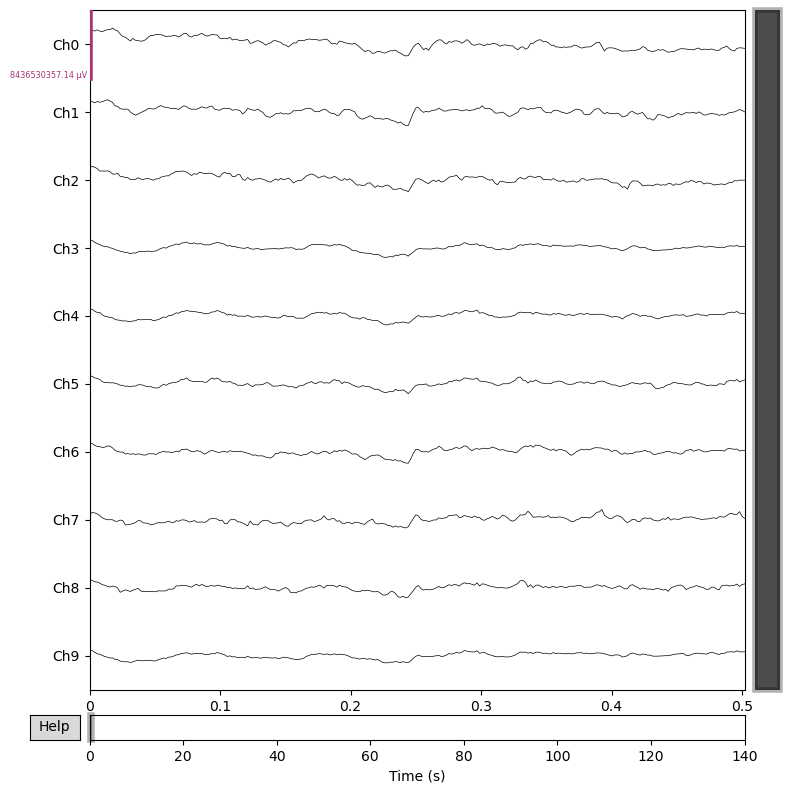

In [16]:
import matplotlib.pyplot as plt
# Plot raw EEG signals
raw.plot(duration=0.5, picks = raw.ch_names[:10], scalings="auto")
plt.show()

In [18]:
# =======================================================================================
# 2. Basic pre‑processing – band‑pass, notch, re‑referencing
# =======================================================================================
raw.filter(1, 40, fir_design='firwin', phase='zero-double')
raw.notch_filter(60, fir_design='firwin')
raw_filtered = raw.set_eeg_reference('average', projection=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-12 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz

C:\Users\10346\AppData\Local\Temp\ipykernel_33136\3260692821.py:6: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw_filtered = raw.set_eeg_reference('average', projection=True)


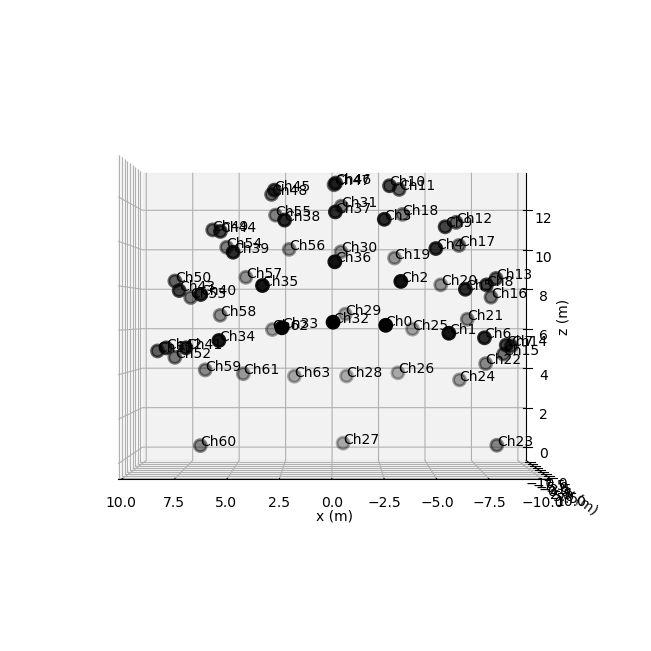

In [25]:
import matplotlib.pyplot as plt

num_channels = sensor_location.shape[0]
ch_names = [f"Ch{i}" for i in range(num_channels)]
montage_dict = {ch: sensor_location[i] for i, ch in enumerate(ch_names)}
montage = mne.channels.make_dig_montage(ch_pos=montage_dict, coord_frame="head")

raw.pick([f"Ch{i}" for i in range(64)])
raw.set_montage(montage)

raw.plot_sensors(kind='3d', show_names=True)

plt.show()


In [19]:
# =======================================================================================
# 3. ICA artifact removal
# =======================================================================================
ica = mne.preprocessing.ICA(n_components=45, method='infomax', max_iter='auto', random_state=97)
ica.fit(raw_filtered.copy().filter(1., None))    
# ica.detect_artifacts(raw_filtered, random_state=97)    
raw_filtered_ica = ica.apply(raw_filtered)


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 s)

Fitting ICA to data using 68 channels (please be patient, this may take a while)
Selecting by number: 45 components
Computing Infomax ICA
Fitting ICA took 65.0s.


AttributeError: 'ICA' object has no attribute 'detect_artifacts'

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 64 channels>


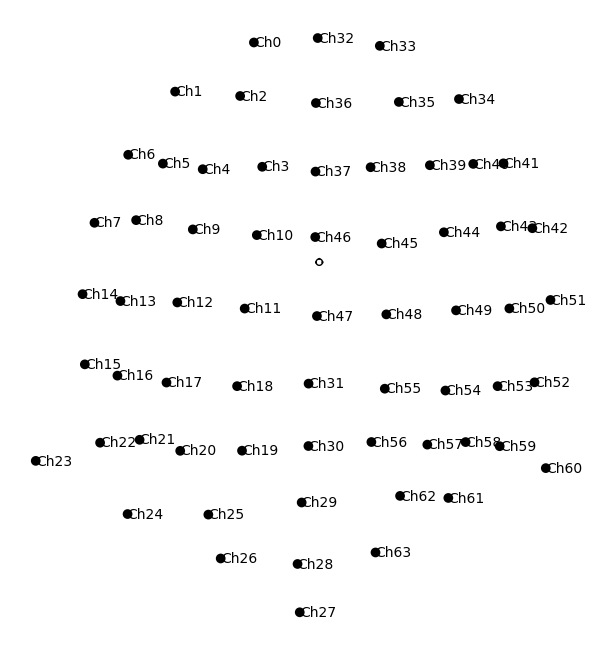

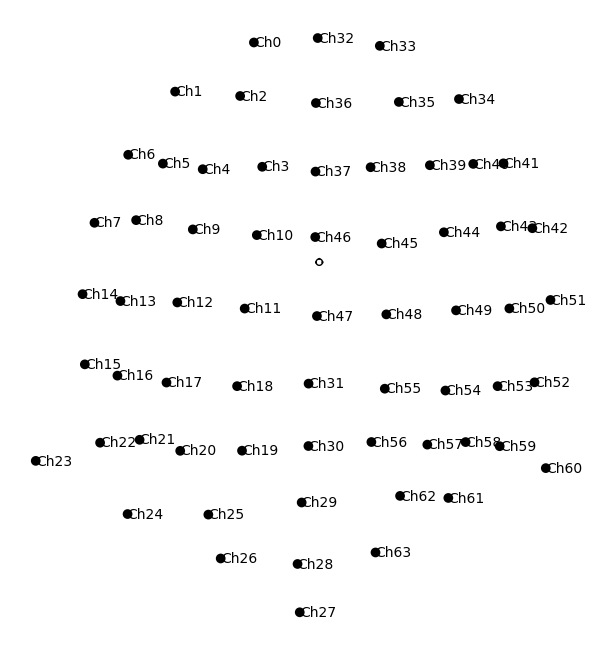

In [31]:
print(raw.get_montage())
raw.plot_sensors(kind='topomap', show_names=True)
